<a href="https://colab.research.google.com/github/grenetercordovesdelgado/Ejercicios/blob/main/detection_deception_based_HRV_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libraries

In [1]:
!pip install hrv-analysis
!pip install pyhrv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spectrum: filename=spectrum-0.8.1-cp39-cp39-linux_x86_64.whl size=237791 sha256=2353b658c78ef3ebafea9abbe0fe47def7b87966769ff1e00c320d5bc6777875
  Stored in directory: /root/.cache/pip/wheels/a0/03/05/e7ced8d2ae677d5c887dafb37619e6f0f978b2f5e60b5cd8e9
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64216 sha256=2fc7e361bba56d550b56b6e77b346cd0d557cf53

# Importing libraries and packages 

In [43]:
from google.colab import drive

import os
import sys
import cv2
from glob import glob
import glob
from tqdm.notebook import tqdm_notebook
import pandas as pd
import numpy as np
from joblib import dump
from skimage import io

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
from IPython.display import Image

import pyhrv.time_domain as td
import hrvanalysis
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_geometrical_features
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_csi_cvi_features
from hrvanalysis import get_poincare_plot_features
from hrvanalysis import get_sampen

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Definition of functions

In [3]:
# Characteristics of an HRV signal

def extract_features(vector):
  all_features = np.array([])

  # Time domain
  time_domain = get_time_domain_features(vector)
  all_features = np.append(all_features, np.array(list(time_domain.values())))
  
  # Signal complexity
  cscv = get_csi_cvi_features(vector)
  all_features = np.append(all_features, np.array(list(cscv.values())))

  # Characteristics Poincaré graph: visualizes relationships between the time intervals between successive heartbeats
  pp = get_poincare_plot_features(vector)
  all_features = np.append(all_features, np.array(list(pp.values())))

  # Calcular la Entropía Aproximada de la Señal HRV o el Entropía de Patrón de Amplitud
  se = get_sampen(vector)
  all_features = np.append(all_features, np.array(list(se.values())))

  # Mean square deviation of the time intervals between consecutive beats
  rmssd = td.rmssd(vector)
  all_features = np.append(all_features, np.array(rmssd))

  return all_features

def statistics(vector):
    max = np.max(vector)
    min = np.min(vector)
    st = np.std(vector)
    mean = np.mean(vector)
    vector = np.array([max, min, st, mean])

    return vector

# Loading training data 

In [104]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# Loading CSV files 
csv_files = [os.path.abspath(x) for x in glob.glob('/content/drive/MyDrive/datos fisiologicos/*/[!Test]*.csv')]

file_label = []
file_path = []

# Paths and labels to the files found
for path in tqdm_notebook(csv_files):
    part = os.path.basename(path)
    part = part.split('.')[0]       
    label = part.split('_')[2]
    file_label.append(label)
    file_path.append(path)  

# Creating dataframe
label_df = pd.DataFrame(file_label, columns=['Label'])
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([label_df, path_df], axis = 1) 

  0%|          | 0/41 [00:00<?, ?it/s]

# Data Exploration

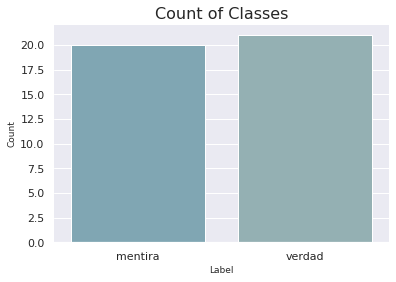

In [106]:
count_label = dataset_df.groupby('Label').count().reset_index()
label = np.array(count_label['Label'])

dataPath = pd.concat([dataset_df], axis = 0)
plt.title('Count of Classes', size=16)
sns.set_theme(palette="blend:#7AB,#EDA")
sns.countplot(x=dataPath["Label"])
plt.xlabel('Label', size=9)
plt.ylabel('Count', size=9)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

# Data processing

In [ ]:
#Get feature vector

df_features = pd.DataFrame()

for path, label in zip(tqdm_notebook(dataset_df.Path), dataset_df.Label): 
         # Loading csv data
         df = pd.read_csv(path, delimiter=',',skiprows=112, skipinitialspace=True)
         v = np.array(df.iloc[:,2])
         v = list(filter(lambda x: x != '', v))
         v = np.array(v)
         v = v[~np.isnan(v)]

         # Obtaining characteristics
         features = extract_features(v)

         v2 = np.fft.fft(v)
         v2 = np.real(v2)
         features_statistics = statistics(v2)
         vector_features = np.concatenate((features, features_statistics))

         features_array = np.append(vector_features, label)
         df_features = pd.concat([df_features, pd.DataFrame(features_array).T], axis=0)

         # Characteristics that the value is to be made zero
         df_features = df_features.drop([3, 4 ,5 ,6], axis=1)

print("Number of instances:", df_features.shape[0])
print("Number of features:", df_features.shape[1]-1)

  0%|          | 0/41 [00:00<?, ?it/s]

Number of instances: 41
Number of features: 24


# Clasification Model

## Normalize data

In [108]:
X = df_features.iloc[:, 0:df_features.shape[1]-2]
Y = df_features.iloc[:, df_features.shape[1]-1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Exporting normalized features to CSV file

In [109]:
Features = pd.DataFrame(X, Y)
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
28,,,,,,,,,,,,,,,,,,,,,
mentira,0.765298,0.985807,0.486999,0.486406,0.843429,0.294840,0.149084,0.383727,-0.740389,-0.524920,...,0.735371,0.482536,0.487017,1.004142,0.013856,0.285111,0.486406,0.039367,0.358035,0.494764
verdad,1.712786,-0.046857,0.512676,0.512084,1.809148,0.579470,-0.236556,-0.792572,-1.353281,-0.766613,...,0.357530,-0.479238,0.515175,-0.090527,-0.577397,1.099940,0.512084,-0.144240,0.500019,0.793130
verdad,1.551528,-0.345484,0.234034,0.234945,1.570157,-0.559052,-0.420186,-0.955599,-1.265345,-1.353103,...,0.117087,-0.591889,0.237049,-0.380407,-0.582849,-0.001699,0.234945,-0.370297,-0.063249,0.500315
mentira,-0.115204,2.096485,0.669073,0.669242,-0.073517,1.701249,0.837137,1.916308,0.005733,0.884021,...,1.129843,1.570207,0.665680,2.149871,0.471480,-0.268993,0.669242,0.653324,-1.445318,0.551561
mentira,-1.258151,0.738132,0.310629,0.309984,-1.322125,1.801707,1.256097,1.566151,1.249268,1.419865,...,0.580686,0.357925,0.307434,0.759113,0.008647,-1.623723,0.309984,-0.094639,-1.717357,-0.710926


## Splitting data

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, shuffle=True)

## Models

### Decision Tree Classifier

#### Initialize model, Training and Predicting

In [111]:
# Initialize model
model_dt = DecisionTreeClassifier()

# Training model
model_dt.fit(X_train, Y_train)

# Predicting for the test set
Y_pred_dt = model_dt.predict(X_test)

#### Confusion matrix and metrics

              precision    recall  f1-score   support

     mentira       0.43      0.75      0.55         4
      verdad       0.75      0.43      0.55         7

    accuracy                           0.55        11
   macro avg       0.59      0.59      0.55        11
weighted avg       0.63      0.55      0.55        11



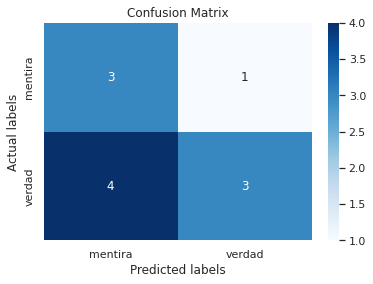

In [113]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred_dt)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_label.Label)
ax.yaxis.set_ticklabels(count_label.Label);

# metrics
print(classification_report(Y_test, Y_pred_dt))

### Naive Bayes Classifier

#### Initialize model, Training and Predicting

In [116]:
# Initialize model
model_nb = GaussianNB()

# Training model
model_nb.fit(X_train, Y_train)

# Predicting for the test set
Y_pred_nv = model_nb.predict(X_test)

#### Confusion matrix and metrics

              precision    recall  f1-score   support

     mentira       0.75      0.75      0.75         4
      verdad       0.86      0.86      0.86         7

    accuracy                           0.82        11
   macro avg       0.80      0.80      0.80        11
weighted avg       0.82      0.82      0.82        11



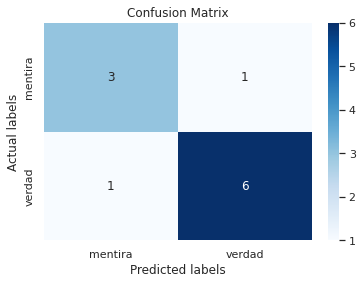

In [118]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred_nv)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_label.Label)
ax.yaxis.set_ticklabels(count_label.Label);

# metrics
print(classification_report(Y_test, Y_pred_nv))

### Support Vector Machines (SVM)

#### Initialize model, Training and Predicting

In [119]:
# Initialize model
model_svc = SVC(kernel='linear')

# Training model
model_svc.fit(X_train, Y_train)

# Predicting for the test set
Y_pred_svm = model_svc.predict(X_test)

#### Confusion matrix and metrics

              precision    recall  f1-score   support

     mentira       0.50      0.75      0.60         4
      verdad       0.80      0.57      0.67         7

    accuracy                           0.64        11
   macro avg       0.65      0.66      0.63        11
weighted avg       0.69      0.64      0.64        11



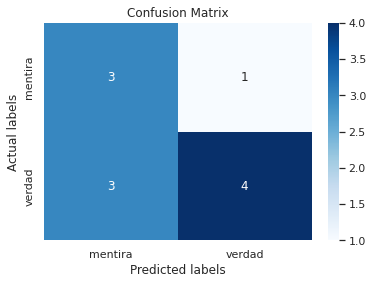

In [120]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, Y_pred_svm)
sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(count_label.Label)
ax.yaxis.set_ticklabels(count_label.Label);

# metrics
print(classification_report(Y_test, Y_pred_svm))

## Leave-One-Out Cross-Validation

In [121]:
Xx = np.array(X)
Yy = np.array(Y)

# Models to test
models = [ SVC(), GaussianNB(), DecisionTreeClassifier()]

# Initialize LOOCV
loo = LeaveOneOut()

# inicializamos una lista para almacenar los resultados de cada modelo
results = []

# realizamos la validación cruzada dejando uno fuera para cada modelo
for model in models:
    result = []
    for train_index, test_index in loo.split(X,y):
        # Split
        Xx_train, Xx_test = Xx[train_index], Xx[test_index]
        Yy_train, Yy_test = Yy[train_index], Yy[test_index]

        # Training
        model.fit(Xx_train, Yy_train)

        # Evaluating model
        score = model.score(Xx_test, Yy_test)

        # Save result
        result.append(score)

    # Average prediction error
    error = 1 - sum(result) / len(result)

    # Save result
    results.append(error)

# Selection of the best model
index = results.index(min(results))
best_model = models[index]

print('The best model is: ', best_model, ' with average prediction error: ', min(results))


The best model is:  GaussianNB()  with average prediction error:  0.3902439024390244


## Re-training the model

In [122]:
# Initialize the Multilayer-Perceptron Classifier
model_nb = GaussianNB()

# Re-training the model
X_nb = scaler.fit_transform(X)
Y_nb = Y
model_nb.fit(X,Y)

GaussianNB()

In [185]:
#Saving the model
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_nb, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Naive_Bayes_Model = pickle.load(file)
Naive_Bayes_Model

GaussianNB()

# External validation

## Loading test data 

In [181]:
# Loading CSV files 
csv_files = [os.path.abspath(x) for x in glob.glob('/content/drive/MyDrive/datos fisiologicos/*/[Test]*.csv')]

file_name = []
file_path = []

# Paths and labels to the files found
for path in tqdm_notebook(csv_files):
    part = os.path.basename(path)
    name = part.split('.')[0]       
    file_name.append(name)
    file_path.append(path)  

# Creating dataframe
file_name_df = pd.DataFrame(file_name, columns=['File_Name'])
path_df = pd.DataFrame(file_path, columns=['Path'])
dataset_df = pd.concat([path_df], axis = 1) 

  0%|          | 0/4 [00:00<?, ?it/s]

## Get feature vector

In [182]:
df_features = pd.DataFrame()

for path in tqdm_notebook(dataset_df.Path): 
  # Loading csv data
  df = pd.read_csv(path, delimiter=',',skiprows=112, skipinitialspace=True)
  v = np.array(df.iloc[:,2])
  v = list(filter(lambda x: x != '', v))
  v = np.array(v)
  v = v[~np.isnan(v)]

  # Obtaining characteristics
  features = extract_features(v)

  v2 = np.fft.fft(v)
  v2 = np.real(v2)
  features_statistics = statistics(v2)
  vector_features = np.concatenate((features, features_statistics))

  df_features = pd.concat([df_features, pd.DataFrame(vector_features).T], axis=0)

  # Characteristics that the value is to be made zero
  df_features = df_features.drop([3, 4 ,5 ,6], axis=1)

print("Number of instances:", df_features.shape[0])
print("Number of features:", df_features.shape[1]-1)

  0%|          | 0/4 [00:00<?, ?it/s]

Number of instances: 4
Number of features: 23


## Normalize data

In [183]:
X = df_features.iloc[:, 0:df_features.shape[1]-1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Evaluating model 

In [190]:
prediction = Naive_Bayes_Model.predict(X)

# Creating dataframe
pred_df = pd.DataFrame(prediction, columns=['Prediction'])
prediction_df = pd.concat([file_name_df, pred_df], axis = 1) 

print('Naive Bayes Model prediction:\n\n', prediction_df)

Naive Bayes Model prediction:

   File_Name Prediction
0  Test_001    mentira
1  Test_002     verdad
2  Test_003    mentira
3  Test_004     verdad
